In [374]:
import numpy as np
import pandas as pd
from google.cloud import storage
from google.oauth2 import service_account
from google.cloud import bigquery
from datetime import datetime
from sdv.single_table import CTGANSynthesizer,TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sklearn import preprocessing,metrics
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as Func
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pandas_gbq
import json
from mlxtend.evaluate import bias_variance_decomp
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.svm import OneClassSVM
import statistics
from catboost import CatBoostClassifier
import os

os.environ['SCIPY_ARRAY_API'] = '1'

In [375]:
with open("finops-55-0c8185e843cd.json","r") as f:
    json_data=json.load(f)
f.close()
cred = service_account.Credentials.from_service_account_info(json_data)
client = bigquery.Client(project=json_data['project_id'],credentials=cred)


In [376]:
QUERY = (
    '''SELECT * from `finops-55.billing_1.synthesized_data_pseudo_label3_thres_51`''' )
query_job = client.query(QUERY)  # API request
df_model=query_job.to_dataframe()


/opt/anaconda3/envs/venv/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [377]:
df_model.shape

(151795, 18)

In [378]:
import os

# Set the environment variable before importing sklearn or scipy
os.environ['SCIPY_ARRAY_API'] = '1'

In [379]:
df_model['is_anomaly'].value_counts()

is_anomaly
0    144205
1      7590
Name: count, dtype: Int64

In [380]:
def preprocessing_all(df):
    for i in df.select_dtypes(include='object').columns:
        df[i] = df[i].str.lower()
        if df[i].isnull().sum()/len(df)>0 and i not in ['regionname','servicecategory']:
            print(i,df[i].isnull().sum())
            df[i].fillna(df.groupby(['cloud','servicename'])[i].transform(statistics.mode),inplace=True)
        elif df[i].isnull().sum()/len(df)>0 and i=='regionname':
            df[i].fillna(statistics.mode(df[i]),inplace=True)
        elif df[i].isnull().sum()/len(df)>0 and i=='servicecategory':
            df[i].fillna('Other',inplace=True)
    for i in df.select_dtypes(include=np.number).columns:
        if df[i].isnull().sum()/len(df)>0:
            df[i].fillna(df.groupby(['cloud','servicename'])[i].transform('mean'),inplace=True)
    return df

            

In [383]:
df_model['listcost'].skew()

np.float64(257.9146726498099)

In [385]:
df_model['listcost'].skew()

np.float64(257.9146726498099)

In [386]:
y = df_model['is_anomaly']
x = df_model.drop('is_anomaly',axis=1)
for i in ['chargeperiodstart_month', 'chargeperiodstart_day','chargeperiodstart_year']:
    x[i] = x[i].astype('str')
x_temp, x_test1, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)
x_train1, x_val1, y_train1, y_val = train_test_split(x_temp, y_temp, test_size=0.125, random_state=42,stratify=y_temp)
# print(x_train.shape,x_val1.shape,x_test1.shape)
# overlap = pd.merge(x_train, x_test, how='inner')
# mask = x_train.apply(tuple, axis=1).isin(overlap.apply(tuple, axis=1))
# x_train1 = x_train[~mask]
# y_train1 = y_train[~mask]
x_train_scaled = preprocessing_all(x_train1)
x_val_scaled = preprocessing_all(x_val1)
x_test_scaled = preprocessing_all(x_test1)
# print(x_train_scaled.shape,x_val_scaled.shape,x_test_scaled.shape)
x_test=x_test1.copy()
x_val=x_val1.copy()
x_train = x_train1.copy()
y_train = y_train1.copy()






consumedunit 1316
pricingcategory 1357
pricingunit 1324


/var/folders/xl/c80qvx9n3mg7_rtyjf_s4v_00000gn/T/ipykernel_1859/232634819.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].fillna(df.groupby(['cloud','servicename'])[i].transform(statistics.mode),inplace=True)
/var/folders/xl/c80qvx9n3mg7_rtyjf_s4v_00000gn/T/ipykernel_1859/232634819.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate ob

consumedunit 180
pricingcategory 206
pricingunit 164
consumedunit 375
pricingcategory 410
pricingunit 365


/var/folders/xl/c80qvx9n3mg7_rtyjf_s4v_00000gn/T/ipykernel_1859/232634819.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].fillna(df.groupby(['cloud','servicename'])[i].transform(statistics.mode),inplace=True)
/var/folders/xl/c80qvx9n3mg7_rtyjf_s4v_00000gn/T/ipykernel_1859/232634819.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate ob

In [387]:
#Train and balancing
print(x_train_scaled.shape,x_test_scaled.shape,x_val_scaled.shape)
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
x_train_cat = encoder.fit_transform(x_train_scaled.select_dtypes(include="object"))
x_train_cat = pd.DataFrame(x_train_cat, columns=encoder.get_feature_names_out(x_train_scaled.select_dtypes(include="object").columns),index=x_train_scaled.index)
print(x_train_cat.shape)
scaler = preprocessing.StandardScaler()
train_scaled_num = scaler.fit_transform(x_train_scaled.select_dtypes(include=np.number))
print(train_scaled_num.shape)
train_scaled_num = pd.DataFrame(train_scaled_num,columns=x_train_scaled.select_dtypes(include=np.number).columns,index=x_train_scaled.index)
print(train_scaled_num.shape)
x_train_balanced = pd.concat([train_scaled_num,x_train_cat],axis=1)
x_train_balanced = x_train_balanced.fillna(0)
print(x_train_balanced.shape)
smote = SMOTE(sampling_strategy='minority',random_state=0,k_neighbors=100)
x_train_smote,y_train_smote= smote.fit_resample(x_train_balanced, y_train)
print(x_train_smote.shape)
df_model_balanced_train = pd.concat([x_train_balanced,y_train],axis=1)
x_train = df_model_balanced_train.drop('is_anomaly',axis=1)
y_train = df_model_balanced_train['is_anomaly']
print(x_train_scaled.shape,x_test_scaled.shape,x_val_scaled.shape)




(106256, 17) (30359, 17) (15180, 17)
(106256, 403)
(106256, 4)
(106256, 4)
(106256, 407)
(201886, 407)
(106256, 17) (30359, 17) (15180, 17)


In [388]:
set(x_train_scaled.columns)-set(x_test_scaled.columns)

set()

In [389]:
# Val
x_val_cat = encoder.transform(x_val_scaled.select_dtypes(include="object"))
x_val_cat = pd.DataFrame(x_val_cat, columns=encoder.get_feature_names_out(x_val_scaled.select_dtypes(include="object").columns),index=x_val_scaled.index)
val_scaled = scaler.transform(x_val_scaled.select_dtypes(include=np.number))
x_val_num = pd.DataFrame(val_scaled, columns = x_val_scaled.select_dtypes(include=np.number).columns,index=x_val_scaled.index)
x_val = pd.concat([x_val_cat,x_val_num],axis=1)

#Test
x_test_cat = encoder.transform(x_test_scaled.select_dtypes(include="object"))
x_test_cat = pd.DataFrame(x_test_scaled, columns=encoder.get_feature_names_out(x_test_scaled.select_dtypes(include="object").columns),index=x_test_scaled.index)
test_scaled = scaler.transform(x_test_scaled.select_dtypes(include=np.number))
x_test_num = pd.DataFrame(test_scaled, columns = x_test_scaled.select_dtypes(include=np.number).columns,index=x_test_scaled.index)
x_test = pd.concat([x_test_cat,x_test_num],axis=1)
print(x_train.shape,x_val.shape,x_test.shape)



(106256, 407) (15180, 407) (30359, 407)


In [390]:
order = x_train.columns
x_test = x_test.reindex(columns=order)
x_val = x_val.reindex(columns=order)


In [391]:
pca=PCA(n_components=287)
x_train,x_test,x_val=x_train.fillna(0),x_test.fillna(0),x_val.fillna(0)
x_train_pca=pca.fit_transform(x_train)
x_test_pca=pca.transform(x_test)
x_val_pca = pca.transform(x_val)

In [392]:
x_train_pca.shape

(106256, 287)

### Logistic Regression

In [393]:
logreg = LogisticRegression(random_state=0)
logreg.fit(x_train_pca, y_train)

# Predictions
y_pred_train = logreg.predict(x_train_pca)
y_pred = logreg.predict(x_test_pca)
y_pred_prob = logreg.predict_log_proba(x_test_pca)[:, 1]
# Evaluation
print("Classification Report")
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    100943
         1.0       0.97      0.97      0.97      5313

    accuracy                           1.00    106256
   macro avg       0.99      0.98      0.98    106256
weighted avg       1.00      1.00      1.00    106256

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97     28841
         1.0       0.43      0.86      0.57      1518

    accuracy                           0.94     30359
   macro avg       0.71      0.90      0.77     30359
weighted avg       0.96      0.94      0.95     30359



/opt/anaconda3/envs/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1492: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


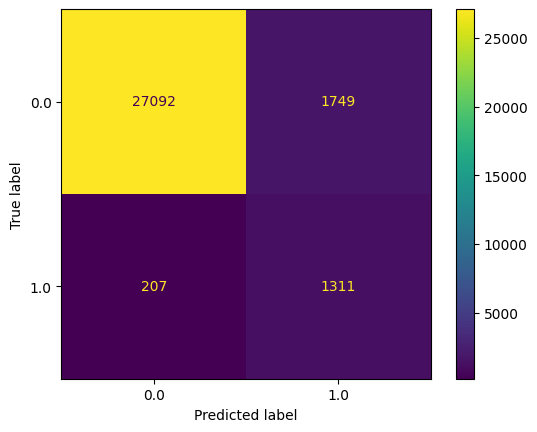

In [394]:
plotcon = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_test,y_pred),display_labels=logreg.classes_)
plotcon.plot()
plt.show()

In [395]:
from sklearn.model_selection import KFold,cross_val_score
kf = KFold(shuffle=True,n_splits=5,random_state=0)
score = cross_val_score(logreg,x_test_pca,y_test,cv=kf,scoring='roc_auc')
np.mean(score)



np.float64(0.9161927434605441)

In [396]:
mse, bias, variance = bias_variance_decomp(
    logreg, np.array(x_train_pca), np.array(y_train), np.array(x_test_pca), np.array(y_test),
    loss='0-1_loss',  # Classification error
    num_rounds=100, 
    random_seed=42
)

In [397]:
mse, bias, variance

(np.float64(0.06190256596067065),
 np.float64(0.06143153595309463),
 np.float64(0.0024974472149939062))

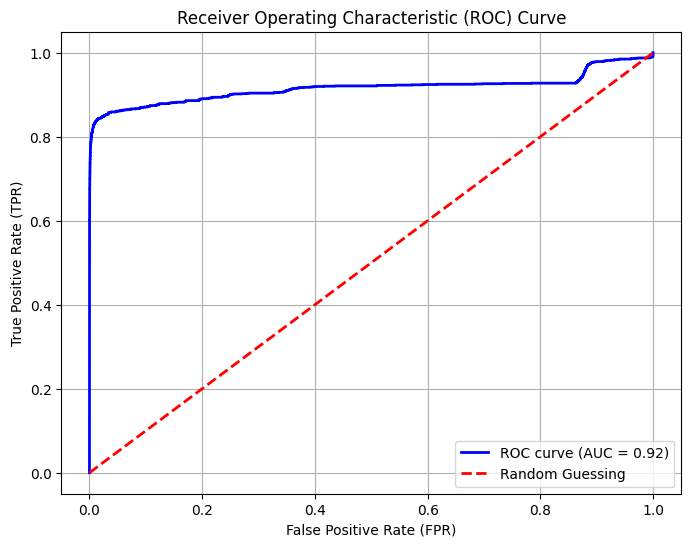

In [398]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate FPR, TPR, and thresholds
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
roc_auc_lg = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lg, tpr_lg, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_lg:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Random Forest

In [399]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(x_train_pca, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [400]:
y_pred_rf = model_rf.predict(x_test_pca)
y_pred_train_rf  =model_rf.predict(x_train_pca)
y_pred_prob_rf = model_rf.predict_proba(x_test_pca)[:, 1]

# Calculate accuracy

# Print a classification report
print("Classification Report: Train")
print(classification_report(y_train, y_pred_train))
print("Classification Report Test")
print(classification_report(y_test, y_pred_rf))


Classification Report: Train
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    100943
         1.0       0.97      0.97      0.97      5313

    accuracy                           1.00    106256
   macro avg       0.99      0.98      0.98    106256
weighted avg       1.00      1.00      1.00    106256

Classification Report Test
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     28841
         1.0       1.00      0.52      0.69      1518

    accuracy                           0.98     30359
   macro avg       0.99      0.76      0.84     30359
weighted avg       0.98      0.98      0.97     30359



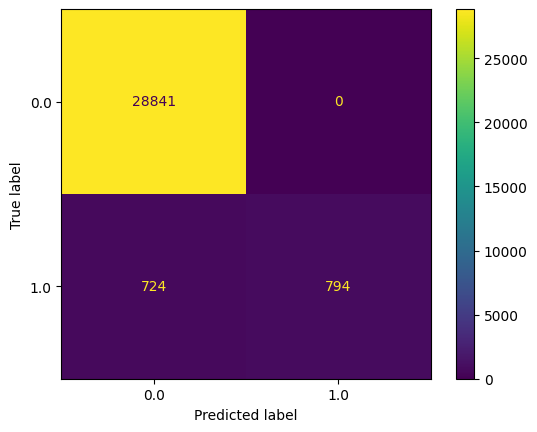

In [401]:
plotcon = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_test,y_pred_rf),display_labels=model_rf.classes_)
plotcon.plot()
plt.show()

In [402]:
from sklearn.model_selection import KFold,cross_val_score
kf = KFold(shuffle=True,n_splits=5,random_state=0)
score = cross_val_score(model_rf,x_test_pca,y_test,cv=kf,scoring='roc_auc')
np.mean(score)


np.float64(0.9853682082997353)

The AUC score is: 0.9239


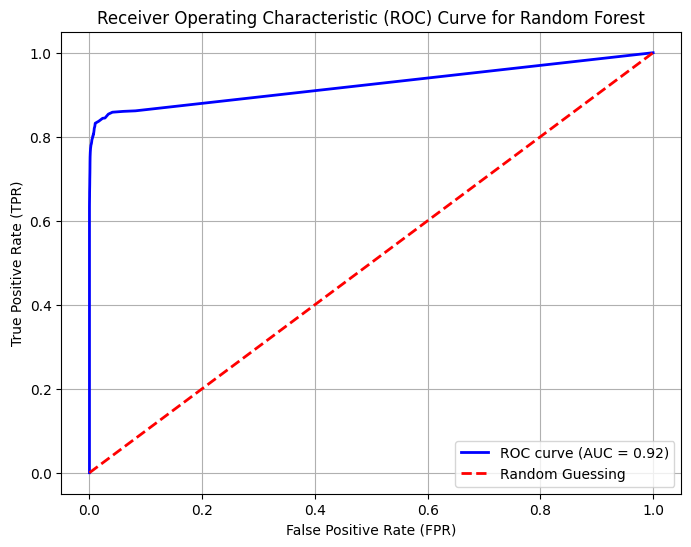

In [403]:
y_pred_prob_rf = model_rf.predict_proba(x_test_pca)[:, 1]

# Calculate FPR, TPR, and thresholds
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)

# Calculate the AUC score
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_rf.png')

print(f"The AUC score is: {roc_auc_rf:.4f}")

In [404]:
from sklearn.model_selection import KFold,cross_val_score
kf = KFold(shuffle=True,n_splits=5,random_state=0)
score = cross_val_score(model_rf,x_test_pca,y_test,cv=kf,scoring='roc_auc')
np.mean(score)


np.float64(0.9853682082997353)

In [406]:
# mse, bias, variance = bias_variance_decomp(
#     model_rf,X_train=np.array(x_train_pca), y_train=np.array(y_train), X_test=np.array(x_test_pca), y_test=np.array(y_test),
#     loss='0-1_loss',  # Classification error
#     num_rounds=10, 
#     random_seed=42
# )
# mse, bias, variance

In [407]:
param_grid = {
    'n_estimators': [50,75,100,125,150,200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [425]:
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, scoring='recall')
grid_search.fit(x_val_pca, y_val)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [50, 75, ...]}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


In [ ]:
y_pred_grid = grid_search.predict(x_test_pca)
print(classification_report(y_test,y_pred_grid))

### KNN

In [409]:
knn = KNeighborsClassifier(n_neighbors=200,weights='distance')
knn.fit(x_train_pca, y_train)

y_pred_knn = knn.predict(x_test_pca)
print(classification_report(y_test, y_pred_knn))
print(metrics.confusion_matrix(y_test,y_pred_knn))
y_pred_prob_knn = knn.predict_proba(x_test_pca)[:, 1]



              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     28841
         1.0       0.98      0.77      0.86      1518

    accuracy                           0.99     30359
   macro avg       0.99      0.88      0.93     30359
weighted avg       0.99      0.99      0.99     30359

[[28820    21]
 [  353  1165]]


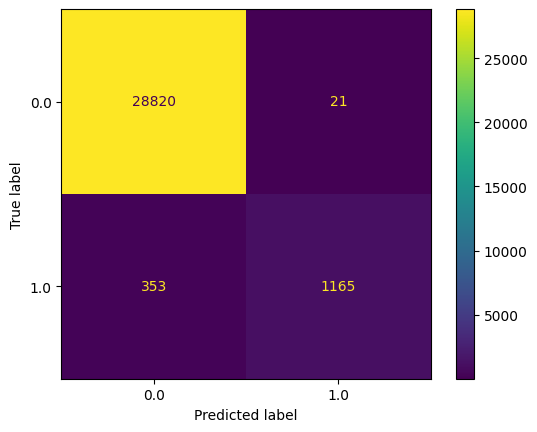

In [410]:
plotcon = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_test,y_pred_knn),display_labels=knn.classes_)
plotcon.plot()
plt.show()

In [411]:
mse, bias, variance = bias_variance_decomp(
    knn, np.array(x_train_pca), np.array(y_train), np.array(x_test_pca), np.array(y_test),
    loss='0-1_loss',  # Classification error
    num_rounds=10, 
    random_seed=42
)
mse, bias, variance

(np.float64(0.012395006423136467),
 np.float64(0.012385124674725781),
 np.float64(0.000510557001218749))

The AUC score is: 0.9370


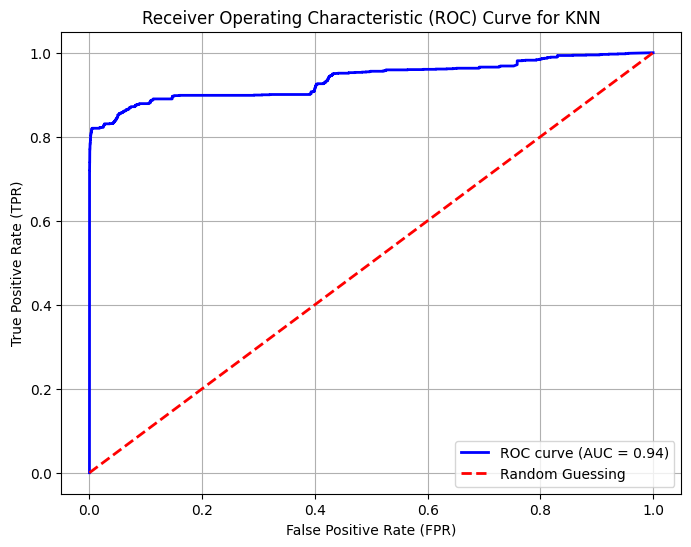

In [413]:
y_pred_prob_knn = knn.predict_proba(x_test_pca)[:, 1]

# Calculate FPR, TPR, and thresholds
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_pred_prob_knn)

# Calculate the AUC score
roc_auc_knn = roc_auc_score(y_test, y_pred_prob_knn)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_rf.png')

print(f"The AUC score is: {roc_auc_knn:.4f}")

### Catboost

In [414]:
categorical_features = x_train1.select_dtypes(include=['object', 'category']).columns.tolist()
for i in categorical_features:
    x_train1[i]=x_train1[i].astype('str')
print(categorical_features)

['billingcurrency', 'chargecategory', 'chargedescription', 'consumedunit', 'pricingcategory', 'pricingunit', 'regionname', 'servicename', 'servicecategory', 'cloud', 'chargeperiodstart_year', 'chargeperiodstart_month', 'chargeperiodstart_day']


In [415]:
model_catboost = CatBoostClassifier(
    iterations=500,
    learning_rate=0.0001,
    depth=6,
    loss_function='Logloss', 
    eval_metric='Recall',         
    random_seed=42,
    verbose=0,
    cat_features = categorical_features
)

model_catboost.fit(x_train1.fillna(''),y_train)
y_pred_cb = model_catboost.predict(x_test1.fillna(''))
y_pred_train = model_catboost.predict(x_train1.fillna(''))
y_pred_prob_cat = model_catboost.predict_proba(x_test1.fillna(''))[:, 1]




importances = model_catboost.get_feature_importance(prettified=True)
print(importances.head(20))

                 Feature Id  Importances
0                billedcost    36.118297
1          consumedquantity    23.093391
2           pricingquantity    18.768970
3           pricingcategory    14.501782
4                     cloud     4.222311
5                  listcost     2.374597
6            chargecategory     0.731773
7           billingcurrency     0.184492
8   chargeperiodstart_month     0.004388
9         chargedescription     0.000000
10             consumedunit     0.000000
11              pricingunit     0.000000
12               regionname     0.000000
13              servicename     0.000000
14          servicecategory     0.000000
15   chargeperiodstart_year     0.000000
16    chargeperiodstart_day     0.000000


In [416]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    100943
         1.0       0.98      0.85      0.91      5313

    accuracy                           0.99    106256
   macro avg       0.98      0.93      0.95    106256
weighted avg       0.99      0.99      0.99    106256



In [417]:
print(classification_report(y_test, y_pred_cb))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     28841
         1.0       0.98      0.69      0.81      1518

    accuracy                           0.98     30359
   macro avg       0.98      0.85      0.90     30359
weighted avg       0.98      0.98      0.98     30359



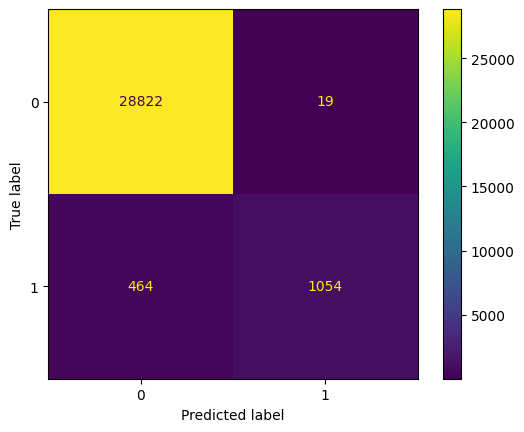

In [418]:
plotcon = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_test,y_pred_cb),display_labels=model_catboost.classes_)
plotcon.plot()
plt.show()

In [426]:
# mse, bias, variance = bias_variance_decomp(
#     model_catboost, np.array(x_train1), np.array(y_train), np.array(x_test1), np.array(y_test),
#     loss='0-1_loss',  # Classification error
#     num_rounds=10, 
#     random_seed=42
# )
# mse, bias, variance

The AUC score is: 0.9917


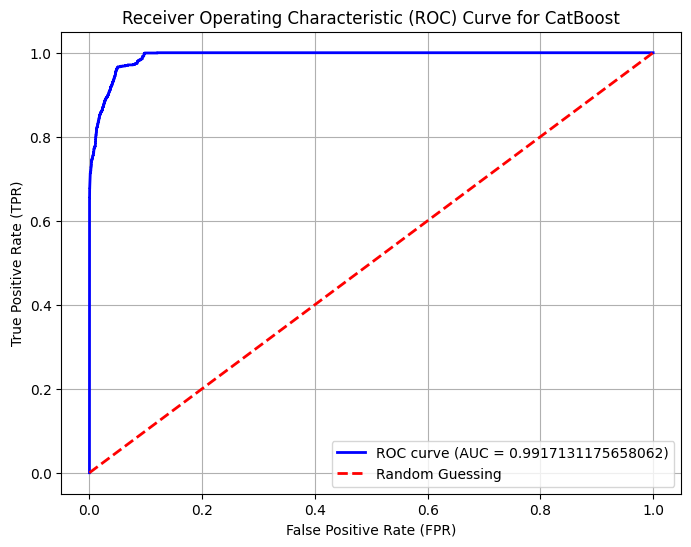

In [420]:
y_pred_prob_cb = model_catboost.predict_proba(x_test1.fillna(''))[:, 1]

# Calculate FPR, TPR, and thresholds
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, y_pred_prob_cb)

# Calculate the AUC score
roc_auc_cb = roc_auc_score(y_test, y_pred_prob_cb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cb, tpr_cb, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_cb})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for CatBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_rf.png')

print(f"The AUC score is: {roc_auc_cb:.4f}")

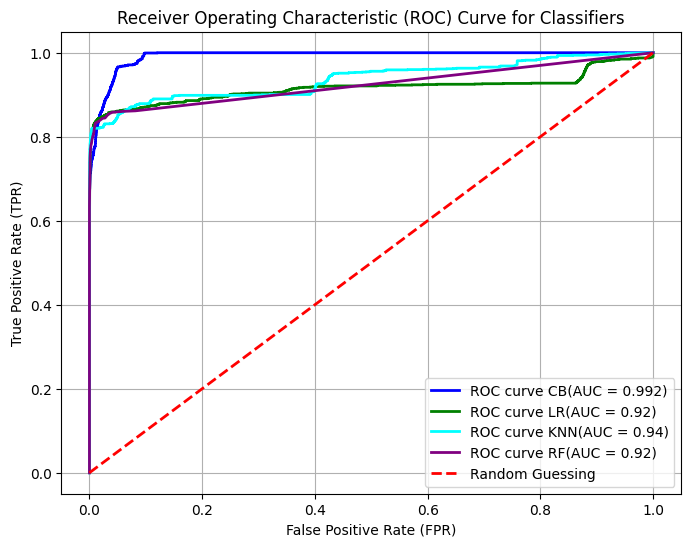

In [421]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_cb, tpr_cb, color='blue', lw=2, label=f'ROC curve CB(AUC = {round(roc_auc_cb,3)})')
plt.plot(fpr_lg, tpr_lg, color='green', lw=2, label=f'ROC curve LR(AUC = {roc_auc_lg:.2f})')
plt.plot(fpr_knn, tpr_knn, color='cyan', lw=2, label=f'ROC curve KNN(AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label=f'ROC curve RF(AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_rf.png')



In [ ]:
train_tuples = set(map(tuple, x_train.values))
test_tuples  = set(map(tuple, x_test.values))
overlap = train_tuples & test_tuples
print(f"Number of overlapping rows: {len(overlap)}")

Number of overlapping rows: 0


In [ ]:
result = pd.concat([x_test1,pd.DataFrame({'is_anomaly':y_pred},index=x_test1.index)],axis=1)

In [ ]:
input_for_recom = result[(result['cloud']=='gcp') & (result['servicename']=='compute engine') & (result['is_anomaly']==1)].sort_values(by='listcost',ascending=False).head(1)

In [ ]:
data_for_input=input_for_recom.to_dict(orient='list')

In [ ]:
data_for_input

{'billingcurrency': ['gbp'],
 'chargecategory': ['usage'],
 'chargedescription': ['n2 instance core running in americas'],
 'consumedunit': ['hours'],
 'pricingcategory': ['standard'],
 'pricingunit': ['hour'],
 'regionname': ['iowa'],
 'servicename': ['compute engine'],
 'servicecategory': ['other'],
 'cloud': ['gcp'],
 'chargeperiodstart_year': ['2025'],
 'chargeperiodstart_month': ['8'],
 'chargeperiodstart_day': ['17'],
 'billedcost': [0.9381152021838967],
 'consumedquantity': [113.62231003732063],
 'pricingquantity': [95.38947356253813],
 'listcost': [3.4156882800401713],
 'is_anomaly': [1.0]}

In [ ]:
with open("input_data_for_recomm.json", "w") as f:
        json.dump(data_for_input, f)
f.close()